<a href="https://colab.research.google.com/github/rhnfzl/image-caption-generator/blob/main/caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5

<b>Group [30]</b>
* <b> Student </b> : Rehan Fazal + 1423002

**Reading material**
* [1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555

**Task:**
Implement and test the image caption generator proposed in [1], see further instructions below. 
Please insert your code between two consecutive occurrences of # ...

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk

import keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate
from tensorflow.keras import losses, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from google.colab import drive

# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

# Mount Google Drive
We will save the data and our model there, in the folder deeplearning2020_ass3_task1.
**This requires about 600 MB**.


In [ ]:
if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('drive', 'My Drive', 'deeplearning2020_ass3_task1')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Download Data - Flickr8k

<b><font color='red'>Please don't distribute the dataset</font></b> 

This is a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

**images:** numpy array (8091,128,128,3), uint8, holding 8091 RGB images.

**captions:** collection of 5 human-annotated captions for each image. Stored as a python list of length 8091. 
*   *captions[i]* is a list of length 5, for i=0..8090, holding the 5 annotations for the i'th image.
*   *captions[i][j]* is a caption, represented as a list of strings, for i=0..8090, j=0..4. 
*   For example: *captions[42][3] = ['a', 'young', 'boy', 'wearing', 'a', 'red', 'coat', 'is', 'playing', 'in', 'a', 'long', 'tunnel']*.
*   Thus, there are in total 8091 * 5 = 40455 captions.

<b><font color='red'>Please don't distribute the dataset</font></b> 

In [ ]:
if not os.path.isdir('drive'):
  raise AssertionError('Google drive seems to be unmounted -- please run cell above.')
  
flickr_file = os.path.join(base_path, 'Flickr8k_processed.pkl')

if not os.path.isfile(flickr_file):
  start_time = time.time()
  if not os.path.isfile(flickr_file):
    ! wget https://surfdrive.surf.nl/files/index.php/s/kOIDM5tQPzv6IID/download -O Flickr8k_processed.pkl
    shutil.move('Flickr8k_processed.pkl', flickr_file)
  print("Elapsed time: {} seconds.".format(time.time()-start_time))
else:
  print('Found file {}'.format(flickr_file))

images, captions = pickle.load(open(flickr_file, 'rb'))

print('Data loaded.')
print('images: {} {} {}'.format(images.shape, type(images), images.dtype))
print('captions: {} {}'.format(len(captions), type(captions)))

Found file drive/My Drive/deeplearning2020_ass3_task1/Flickr8k_processed.pkl
Data loaded.
images: (8091, 128, 128, 3) <class 'numpy.ndarray'> uint8
captions: 8091 <class 'list'>


# Extract Image Representation

* Use the 'Conv_1' layer from *MobileNetV2* to generate neural codes for each image in the array *images*. 
* Please generate a (8091,20480) numpy array in single precision (dtype=np.float32) holding the neural codes, where each row holds the code for the corresponding row in *images*. 
* Call the resulting array *image_codes*.
* **Hint:** Process the images in batches (of e.g. 200), as the GPU won't be able to process all 8091 images in parallel.
* **Hint:** MobileNetV2 requires images in floating point as inputs, with pixels rescaled to range [-1,1]. In order to save some RAM (and reduce troubles with Colab running out of resources), convert only the batches into single precision, and keep the *images* in their original format (uint8).

In [ ]:
def get_image_codes(images):      
  convnet = MobileNetV2(input_shape=(128,128,3), 
                          include_top=False, 
                          weights='imagenet')

  # Use the 'Conv_1' layer from MobileNetV2 to generate neural codes for each image in the array images
  inpt = convnet.input
  output = convnet.get_layer("Conv_1").output
  conv_1 = K.function([inpt],[output])
  
  image_codes=np.empty((8091,20480), dtype=np.float32)
  for i in range(87):
    neural_codes = conv_1(images[93*i: 93*(i+1)])[0]
    for k in range(93):
      image_codes[i*93+k]=neural_codes[k].flatten()
  return image_codes

image_codes = get_image_codes(images)
print(image_codes.shape)

(8091, 20480)


# Analyze Captions

* Find the maximal caption length in the *captions* and store it in a variable *max_caption_length*.
* Construct a collection of all words (i.e. strings) occurring in the captions, and count their occurrences. 
Include the special word '_' (the *stop word*, signaling the end of the captions) in this collection.
* Construct a dictionary *word_to_idx* which maps words to integers as follows:
    *   '_' ->  0
    *   most frequent word -> 1
    *   second most frequent word -> 2
    *   ...

* Construct a dictionary *idx_to_word* which inverts the mapping *word_to_idx*.
* Store the number of unique words, including '_', in a variable *num_words*.

In [ ]:
max_caption_length = 0
word_dict = {}
for i in range(8091):#get the number of appearances for every word
  for j in range(5):
    line = captions[i][j]
    max_caption_length = max(max_caption_length,len(line))
    for k in range(len(line)):
      word=line[k]
      if word not in word_dict:
        word_dict[word] = 1
      else:
        word_dict[word] += 1
max_caption_length += 1 #for the final '_'

word_to_idx = {}
idx_to_word = {}
# '_' -> 0
word_to_idx["_"]=0
idx_to_word[0]="_"
idx=1
for k,v in sorted(word_dict.items(), key=lambda item: item[1], reverse=True):
  word_to_idx[k]=idx
  idx_to_word[idx]=k
  idx += 1
word_dict["_"]=8091*5 #Include the special word '_', one for every caption
num_words = len(word_dict)

print(len(word_dict))
print(len(word_to_idx))
print(len(idx_to_word))

2992
2992
2992


# Train/Validation/Test Split

In [ ]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]

# Convert Train and Validation Data into Matrix Format

This encodes the captions to integer matrices using the mapping *word_to_idx*. 
It also duplicates the corresponding image codes.
The result is two matrices {train, val}_codes and {train, val}_y, which hold image codes and integer encoded captions, whose rows correspond to each other.

In [ ]:
def convert_data(codes, captions, max_caption_length, word_to_idx):
  if codes.shape[0] != len(captions):
    raise AssertionError("Different number of codes and captions.")
  
  N = codes.shape[0]
  duplicate_codes = None
  labels = None
  for k in range(5):
    cur_labels = np.zeros((N, max_caption_length), dtype=np.uint32)
    for l in range(N):
      for count, w in enumerate(captions[l][k]):
        cur_labels[l, count] = word_to_idx[w]

    if duplicate_codes is None:
      duplicate_codes = codes
      labels = cur_labels
    else:
      duplicate_codes = np.concatenate((duplicate_codes, codes), 0)
      labels = np.concatenate((labels, cur_labels), 0)
  
  return duplicate_codes, labels

train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(30455, 20480)
(30455, 36)
(5000, 20480)
(5000, 36)


# Show Random Images from Train and Validation Sets


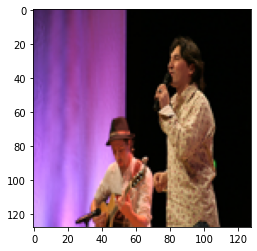

['a', 'dark', 'haired', 'man', 'standing', 'up', 'singing', 'and', 'a', 'man', 'in', 'a', 'brown', 'hat', 'sitting', 'playing', 'guitar', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





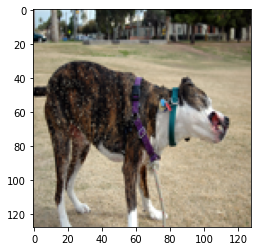

['a', 'big', 'dog', 'shakes', 'dry', 'grass', 'off', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





In [ ]:
def show_random_image_and_captions(images, labels, idx_to_word):
  n = images.shape[0]
  idx = np.random.randint(0, n)

  plt.imshow(images[idx % images.shape[0], ...])
  plt.show()

  encoded_caption = labels[idx, ...]
  encoded_caption = [k for k in encoded_caption if k >= 0]
  caption = [idx_to_word[i] for i in encoded_caption]
  print(caption)
  print('\n\n')

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)

# Make Model

The model takes two inputs:

*   *image_input*: placeholder for image codes.
*   *caption_inputs*: placeholder for integer-encoded captions. 

You need to insert the following structure:

*   Image embedding: *Dense* layer, mapping image codes to embeddings of length *embedding_dim*.
*   Caption embedding: *Embedding* layer, mapping integers to embeddings of length *embedding_dim*.
*   Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
*   LSTM with *lstm_dim* units, taking the concatenated embedding as input.
*   Apply Dropout with rate 0.5 to the LSTM.
*   Output layer: *Dense* layer, mapping the output of the LSTM to a categorical distribution (via *softmax*) of length *num_words*.

**Hint:** The function K.expand_dims() might be useful here.



In [ ]:
def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

  # inputs
  image_input = Input(shape=(code_length,))
  caption_input = Input(shape=(max_caption_length -1,))

  #maps neural codes of size 20480 to a vector of dimension embedding_dim
  Image_embedding = Dense(embedding_dim, input_shape=(code_length,), activation="relu")
  Image_embedding = Image_embedding(image_input)
  Image_embedding = K.reshape(Image_embedding, shape=(-1,1,512))

  #maps (num_words) different words in a caption with size (max_caption_length) to a vector of dimension (embedding_dim)
  Caption_embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_caption_length)
  Caption_embedding = Caption_embedding(caption_input)
  #concatenate the results and get the lstm output
  Embeddings = concatenate([Image_embedding, Caption_embedding],axis=1)
  lstm = LSTM(lstm_dim, dropout=lstm_dropout, return_sequences=True)
  lstm = lstm(Embeddings)

  output = Dense(num_words,activation="softmax")
  output = output(lstm)

  return Model([image_input, caption_input], output)

model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)

# Train Model

* Use Adam with learning rate 0.001 and early stopping with patience 1. 
Provide the separate validation set for early stopping.
* Use a batch size of 100.
* Use a maximal number of epochs of 100 (early stopping will likely stop training much earlier).
* Use crossentropy as loss function.
* Report which data serves as input and which serves as output, and why.
* **Hint:** Use the sparse version of crossentropy, in order to avoid memory issues.

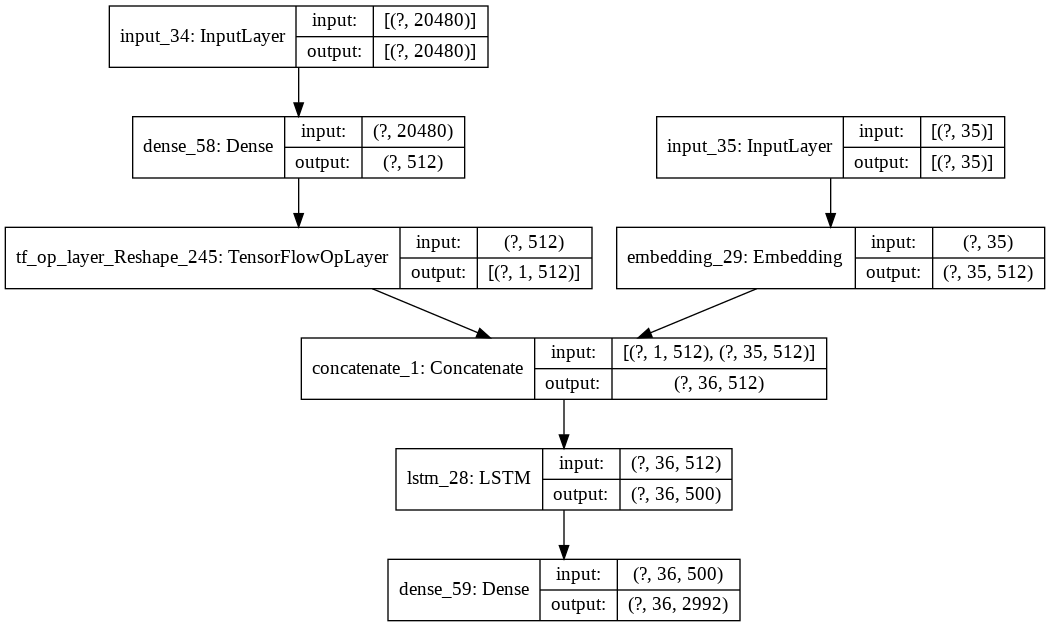

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=1, mode='auto')

Adam = optimizers.Adam(learning_rate=0.001)
Crossentropy = losses.sparse_categorical_crossentropy
model.compile(optimizer=Adam, loss=Crossentropy)
plot_model(model, show_shapes=True)

The input data are the code images (train_codes) and their corresponding captions without one word (train_cap) from the train split. The output is the complete corrresponding captions (train_y). This is because our model receives an image and a caption with a missing word and tries to predict which one should it be. Therefore, in order to train it, we remove for every caption its i-th element (word transformed into integer).

The validation data is created in a similar fashion, but using val_codes and val_y instead of train_codes and train_y

In [ ]:
for i in range(max_caption_length):
  train_cap = np.delete(train_y,i,axis=1)
  val_cap = np.delete(val_y,i,axis=1)
  print("Training the " +str(i+1)+"-th word")
  model.fit(x=[train_codes,train_cap], y=train_y, batch_size=100,callbacks=[early_stopping_callback], validation_data=([val_codes, val_cap],val_y), epochs=3)

model.save(os.path.join(base_path, 'model.h5'))

Training the 1-th word
Epoch 1/3
305/305 [==============================] - 15s 50ms/step - loss: 1.3249 - val_loss: 0.6625
Epoch 2/3
305/305 [==============================] - 15s 49ms/step - loss: 0.4274 - val_loss: 0.2779
Epoch 3/3
305/305 [==============================] - 15s 48ms/step - loss: 0.2047 - val_loss: 0.1603
Training the 2-th word
Epoch 1/3
305/305 [==============================] - 15s 48ms/step - loss: 0.2499 - val_loss: 0.2236
Epoch 2/3
305/305 [==============================] - 15s 48ms/step - loss: 0.1971 - val_loss: 0.1969
Epoch 3/3
305/305 [==============================] - 15s 48ms/step - loss: 0.1770 - val_loss: 0.1833
Training the 3-th word
Epoch 1/3
305/305 [==============================] - 15s 48ms/step - loss: 0.2759 - val_loss: 0.2731
Epoch 2/3
305/305 [==============================] - 15s 49ms/step - loss: 0.2536 - val_loss: 0.2646
Epoch 3/3
305/305 [==============================] - 15s 48ms/step - loss: 0.2465 - val_loss: 0.2607
Training the 4-th word

# Evaluate Model

* Evaluate and report the final train and validation loss

Final train loss: 0.4350

Final validation loss: 1.3059

It looks like the model is very accurate at predicting the train dataset, but it has slowly become worse with the validation dataset. Probably the training is not sufficient however my hardware will not allow to make it more intense



In [ ]:
model = load_model(os.path.join(base_path, 'model.h5'))
model.summary()

# ...

# ...

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 20480)]      0                                            
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 512)          10486272    input_34[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 35)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_Reshape_245 (Tensor (None, 1, 512)       0           dense_58[0][0]                   
___________________________________________________________________________________________

# Make Decoder

* Make a greedy decoder model, which iteratively predicts the most likely word at each time step. The decoder is akin to the trained model above, but with a crucial difference: at time step t (t > 0), the LSTM takes the embedding of the word *predicted at time step t-1* as input. At time t=0, the LSTM takes the image embedding as input.
* The decoder should return the predicted captions, encoded as integer matrix of shape (batch_size, max_caption_length).
* Equip the decoder with the weights of the trained model. 
* **Hint:** You will need to pass on the internal state of the LSTM from time step to time step. To this end, use the argument *return_state=True* when creating the LSTM, and the *initial_state* argument when calling the LSTM. 
* **Hint:** Use the argument *weights* to pass the parameters of the trained model. This should contain the weights for image embedding, word embedding, LSTM, and output layer. Use the methods *get_weights()* and *set_weights()* to this end.
* **Hint:** The functions *K.expand_dims()*, *K.argmax()*, and *K.stack()* might be useful here.

In [ ]:
def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):
  
  # input
  image_input = Input(shape=(code_length,))

  #layers
  Image_embedding = Dense(embedding_dim, input_shape=(code_length,), activation="relu")
  Caption_embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_caption_length)
  lstm = LSTM(lstm_dim, dropout=lstm_dropout, return_sequences=False, return_state=True)
  output = Dense(num_words,activation="softmax")

  embedding = Image_embedding(image_input)
  embedding = K.reshape(embedding, shape=(-1,1,512))
  
  lstm_embedding, state_hidden, state_cell = lstm(embedding)

  word = output(lstm_embedding)
  word = K.argmax(word)
  text = [word]

  for i in range(1,max_caption_length):
    embedding = Caption_embedding(word)
    embedding = K.reshape(embedding, shape=(-1,1,512))
    lstm_embedding, state_hidden, state_cell = lstm(embedding, initial_state=[state_hidden, state_cell])
    word = output(lstm_embedding)
    word = K.argmax(word)
    text.append(word)

  Image_embedding.set_weights(weights[:2])
  Caption_embedding.set_weights([weights[2]])
  lstm.set_weights(weights[3:6])
  output.set_weights(weights[6:])

  return Model(image_input, text)

# Get the weights from trained model, and put them in a list 'weights'.
# ...
weights = model.get_weights()

decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)

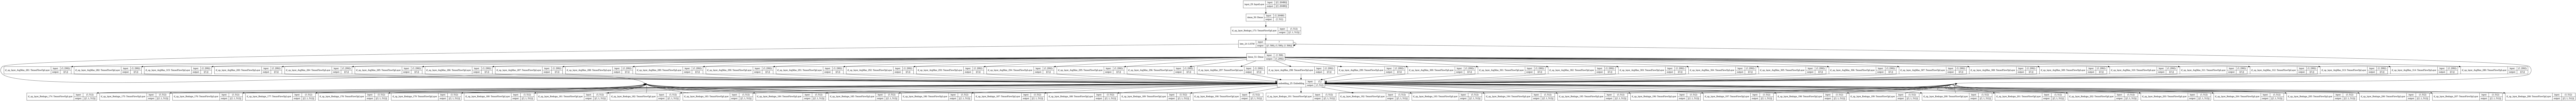

In [ ]:
decoder.compile(optimizer=Adam, loss="categorical_crossentropy")
plot_model(decoder, show_shapes=True)

# Predict Test Captions

*   Use the decoder to predict the test captions.
*   Decode them to text using the mapping *idx_to_word*.
*   Show 10 random test images and their predicted captions. Categorize them like in Figure 5 in the paper.
*   Report the 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores of the test predictions. **Hint:** You can use the *nltk* package for this. 


In [ ]:
test_codes, test_y = convert_data(test_codes, test_captions, max_caption_length, word_to_idx)

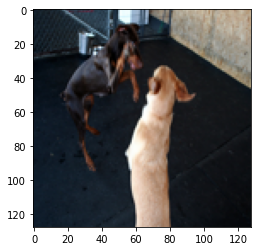

['a', 'man', 'in', 'a', 'red', 'jacket', 'and', 'khaki', 'pants', 'is', 'walking', 'through', 'a', 'part', 'of', 'what', 'looks', 'like']





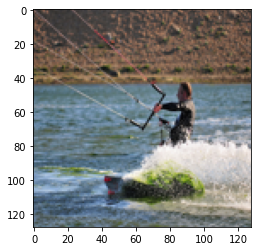

['a', 'man', 'in', 'a', 'red', 'jacket', 'and', 'khaki', 'pants', 'is', 'walking', 'through', 'a', 'part', 'of', 'what', 'looks', 'like']





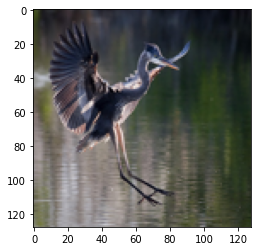

['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'learning', 'how', 'to', 'climb', 'a', 'cliff']





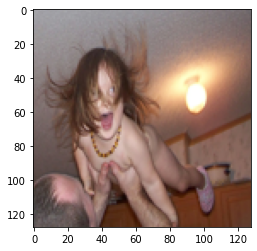

['a', 'man', 'in', 'a', 'red', 'jacket', 'and', 'khaki', 'pants', 'is', 'walking', 'through', 'a', 'part', 'of', 'what', 'looks', 'like']





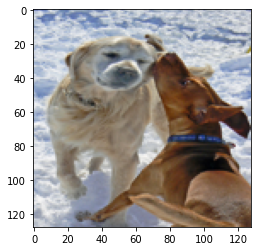

['a', 'man', 'in', 'a', 'red', 'jacket', 'and', 'khaki', 'pants', 'is', 'walking', 'through', 'a', 'part', 'of', 'what', 'looks', 'like']





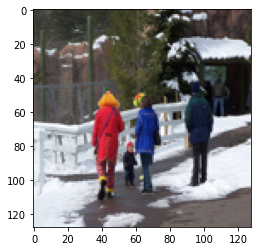

['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'learning', 'how', 'to', 'climb', 'a', 'cliff']





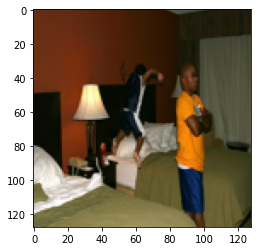

['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'learning', 'how', 'to', 'climb', 'a', 'cliff']





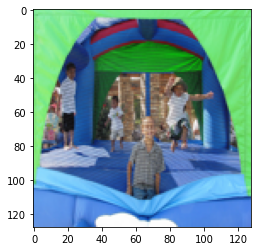

['a', 'man', 'in', 'a', 'red', 'jacket', 'and', 'khaki', 'pants', 'is', 'walking', 'through', 'a', 'part', 'of', 'what', 'looks', 'like']





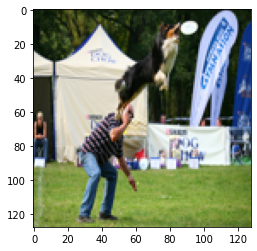

['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'learning', 'how', 'to', 'climb', 'a', 'cliff']





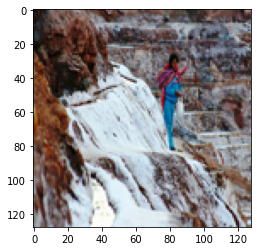

['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'learning', 'how', 'to', 'climb', 'a', 'cliff']





In [ ]:
#train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
def random_image(images, codes ,labels, idx_to_word):
  for k in range(10):
    n = images.shape[0]
    idx = np.random.randint(0, n)
    plt.imshow(images[idx % images.shape[0], ...])
    plt.show()
    code = codes[idx % images.shape[0],...]
    code = K.reshape(code, shape=(1,20480))
    encoded_caption = decoder(code)
    encoded_caption = [int(K.eval(k)) for k in encoded_caption if int(K.eval(k)) > 0]
    caption = [idx_to_word[i] for i in encoded_caption]
    reference = []
    print(caption)
    print('\n\n')

random_image(test_images, test_codes,test_y, idx_to_word)

#show_random_image_and_captions(train_images, train_y, idx_to_word)
# ...

The 1st image: unrelated to the image

The 2nd image: somewhat related to the image

The 3rd image: unrelated to the image

The 4th image: somewhat related to the image

The 5th image: unrelated to the image

The 6th image: somewhat related to the image

The 7th image: somewhat related to the image

The 8th image: unrelated to the image

The 9th image: somewhat related to the image

The 10th image: describes the image without errors

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for k in range(test_images.shape[0]):
    code = test_codes[k % images.shape[0],...]
    code = K.reshape(code, shape=(1,20480))
    encoded_caption = decoder(code)
    encoded_caption = [int(K.eval(k)) for k in encoded_caption if int(K.eval(k)) > 0]
    caption = [idx_to_word[i] for i in encoded_caption]
    
    reference=[]
    for i in range(5):
      reference.append([idx_to_word[j] for j in test_y[k + 1000*i]])
    score = sentence_bleu(reference, caption, weights=(1, 0, 0, 0))
    print("Image number:", (k+1))
    print("1-gram BLEU score:", sentence_bleu(reference, caption, weights=(1, 0, 0, 0)))
    print("2-gram BLEU score:", sentence_bleu(reference, caption, weights=(0, 1, 0, 0)))
    print("3-gram BLEU score:", sentence_bleu(reference, caption, weights=(0, 0, 1, 0)))
    print("4-gram BLEU score:", sentence_bleu(reference, caption, weights=(0, 0, 0, 1)))
    print('\n\n')


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Image number: 1
1-gram BLEU score: 0.0613132401952404
2-gram BLEU score: 0.36787944117144233
3-gram BLEU score: 0.36787944117144233
4-gram BLEU score: 0.36787944117144233



Image number: 2
1-gram BLEU score: 0.08175098692698718
2-gram BLEU score: 0.36787944117144233
3-gram BLEU score: 0.36787944117144233
4-gram BLEU score: 0.36787944117144233



Image number: 3
1-gram BLEU score: 0.039337861063552734
2-gram BLEU score: 0.1704640646087285
3-gram BLEU score: 0.1704640646087285
4-gram BLEU score: 0.1704640646087285



Image number: 4
1-gram BLEU score: 0.07867572212710547
2-gram BLEU score: 0.1704640646087285
3-gram BLEU score: 0.1704640646087285
4-gram BLEU score: 0.1704640646087285



Image number: 5
1-gram BLEU score: 0.039337861063552734
2-gram BLEU score: 0.1704640646087285
3-gram BLEU score: 0.1704640646087285
4-gram BLEU score: 0.1704640646087285



Image number: 6
1-gram BLEU score: 0.14306422712222758
2-gram BLEU score: 0.08655986851092762
3-gram BLEU score: 0.0459849301464303
4

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Image number: 11
1-gram BLEU score: 0.14306422712222758
2-gram BLEU score: 0.021639967127731898
3-gram BLEU score: 0.36787944117144233
4-gram BLEU score: 0.36787944117144233



Image number: 12
1-gram BLEU score: 0.14306422712222758
2-gram BLEU score: 0.021639967127731898
3-gram BLEU score: 0.36787944117144233
4-gram BLEU score: 0.36787944117144233



Image number: 13
1-gram BLEU score: 0.04087549346349358
2-gram BLEU score: 0.36787944117144233
3-gram BLEU score: 0.36787944117144233
4-gram BLEU score: 0.36787944117144233



Image number: 14
1-gram BLEU score: 0.10490096283614063
2-gram BLEU score: 0.056821354869576166
3-gram BLEU score: 0.030993466292496094
4-gram BLEU score: 0.017046406460872854



Image number: 15
1-gram BLEU score: 0.039337861063552734
2-gram BLEU score: 0.1704640646087285
3-gram BLEU score: 0.1704640646087285
4-gram BLEU score: 0.1704640646087285



Image number: 16
1-gram BLEU score: 0.013112620354517579
2-gram BLEU score: 0.1704640646087285
3-gram BLEU score: 0.1

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Se han truncado las últimas 5000 líneas del flujo de salida.
1-gram BLEU score: 0.05245048141807031
2-gram BLEU score: 0.1704640646087285
3-gram BLEU score: 0.1704640646087285
4-gram BLEU score: 0.1704640646087285



Image number: 377
1-gram BLEU score: 0.08175098692698718
2-gram BLEU score: 0.36787944117144233
3-gram BLEU score: 0.36787944117144233
4-gram BLEU score: 0.36787944117144233



Image number: 378
1-gram BLEU score: 0.0655631017725879
2-gram BLEU score: 0.014205338717394041
3-gram BLEU score: 0.1704640646087285
4-gram BLEU score: 0.1704640646087285



Image number: 379
1-gram BLEU score: 0.039337861063552734
2-gram BLEU score: 0.014205338717394041
3-gram BLEU score: 0.1704640646087285
4-gram BLEU score: 0.1704640646087285



Image number: 380
1-gram BLEU score: 0.05245048141807031
2-gram BLEU score: 0.04261601615218213
3-gram BLEU score: 0.030993466292496094
4-gram BLEU score: 0.017046406460872854



Image number: 381
1-gram BLEU score: 0.14306422712222758
2-gram BLEU score: